In [1]:
import os, json
import numpy as np
import pandas as pd
import itertools
from functools import lru_cache
import matplotlib.pyplot as plt
import collections
from tqdm.auto import tqdm
%matplotlib inline

/home/duc/.conda/envs/kddcup/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [54]:
train_data_dir = test_data_dir = '../data'

In [55]:
@lru_cache(maxsize=1)
def read_product_data():
    return pd.read_csv(os.path.join(train_data_dir, 'products_train.csv'))

@lru_cache(maxsize=1)
def read_train_data():
    return pd.read_csv(os.path.join(train_data_dir, 'sessions_train.csv'))

@lru_cache(maxsize=3)
def read_test_data(task):
    return pd.read_csv(os.path.join(test_data_dir, f'sessions_test_{task}.csv'))

In [56]:
products = read_product_data()
sessions = read_train_data()
sessions.prev_items = sessions.prev_items.apply(lambda x: json.loads(x.replace(' ', ',').replace('\'', '"')))

In [57]:
products.head()

,id,locale,title,price,brand,color,size,model,material,author,desc
0,B005ZSSN10,DE,RED DRAGON Amberjack 3 - Steel Tip 22 Gramm Wo...,30.95,RED DRAGON,NaN,NaN,RDD0089,NaN,NaN,Amberjacks Steel Dartpfeile sind verfügbar in ...
1,B08PRYN6LD,DE,Simply Keto Lower Carb* Schokodrops ohne Zucke...,17.90,Simply Keto,NaN,750 g (1er Pack),NaN,NaN,NaN,🌱 NATÜRLICHE SÜSSE DURCH ERYTHRIT - Wir stelle...
2,B09MBZJ48V,DE,"Sennheiser 508377 PC 5.2 Chat, Stilvolles Mult...",68.89,Sennheiser,Multi-Colour,One size,508377,Kunstleder,NaN,3.5 MM BUCHSE - Kann problemlos an Geräte mit ...
3,B08ZN6F26S,DE,AmyBenton Auto ab 1 2 3 ahre - Baby Aufziehbar...,18.99,Amy & Benton,Animal Car,NaN,2008B,aufziehauto 1 jahr,NaN,【Auto aufziehbar】: Drücken Sie einfach leicht ...
4,B094DGRV7D,DE,PLAYMOBIL - 70522 - Cavaliere mit grauem Pony,7.17,PLAYMOBIL,Nicht Zutreffend.,OneSize,70522,Polypropylen,NaN,Inhalt: 1 Stück


In [58]:
sessions.head()

,prev_items,next_item,locale
0,"[B09W9FND7K, B09JSPLN1M]",B09M7GY217,DE
1,"[B076THCGSG, B007MO8IME, B08MF65MLV, B001B4TKA0]",B001B4THSA,DE
2,"[B0B1LGXWDS, B00AZYORS2, B0B1LGXWDS, B00AZYORS...",B0767DTG2Q,DE
3,"[B09XMTWDVT, B0B4MZZ8MB, B0B7HZ2GWX, B09XMTWDV...",B0B4R9NN4B,DE
4,"[B09Y5CSL3T, B09Y5DPTXN, B09FKD61R8]",B0BGVBKWGZ,DE


In [59]:
def read_locale_data(locale, task):
    products = read_product_data().query(f'locale == "{locale}"')
    sess_train = read_train_data().query(f'locale == "{locale}"')
    sess_test = read_test_data(task).query(f'locale == "{locale}"')
    return products, sess_train, sess_test

def show_locale_info(locale, task):
    products, sess_train, sess_test = read_locale_data(locale, task)

    train_l = sess_train['prev_items'].apply(lambda sess: len(sess))
    test_l = sess_test['prev_items'].apply(lambda sess: len(sess))

    print(f"Locale: {locale} \n"
          f"Number of products: {products['id'].nunique()} \n"
          f"Number of train sessions: {len(sess_train)} \n"
          f"Train session lengths - "
          f"Mean: {train_l.mean():.2f} | Median {train_l.median():.2f} | "
          f"Min: {train_l.min():.2f} | Max {train_l.max():.2f} \n"
          f"Number of test sessions: {len(sess_test)}"
        )
    if len(sess_test) > 0:
        print(
             f"Test session lengths - "
            f"Mean: {test_l.mean():.2f} | Median {test_l.median():.2f} | "
            f"Min: {test_l.min():.2f} | Max {test_l.max():.2f} \n"
        )
    print("======================================================================== \n")

In [60]:
task = 'task3'
products = read_product_data()
locale_names = products['locale'].unique()
for locale in locale_names:
    show_locale_info(locale, task)

Locale: DE 
Number of products: 518327 
Number of train sessions: 1111416 
Train session lengths - Mean: 4.35 | Median 3.00 | Min: 2.00 | Max 156.00 
Number of test sessions: 10000
Test session lengths - Mean: 39.92 | Median 27.00 | Min: 27.00 | Max 581.00 


Locale: JP 
Number of products: 395009 
Number of train sessions: 979119 
Train session lengths - Mean: 4.48 | Median 3.00 | Min: 2.00 | Max 474.00 
Number of test sessions: 10000
Test session lengths - Mean: 40.23 | Median 27.00 | Min: 27.00 | Max 436.00 


Locale: UK 
Number of products: 500180 
Number of train sessions: 1182181 
Train session lengths - Mean: 4.12 | Median 3.00 | Min: 2.00 | Max 201.00 
Number of test sessions: 10000
Test session lengths - Mean: 48.85 | Median 40.00 | Min: 27.00 | Max 410.00 


Locale: ES 
Number of products: 42503 
Number of train sessions: 89047 
Train session lengths - Mean: 3.66 | Median 3.00 | Min: 2.00 | Max 60.00 
Number of test sessions: 6421
Test session lengths - Mean: 44.70 | Median 4

# Data Analysis


## Objectives
 - Which data are valid?
 - Which features could be valuable for the Recommendation System?
 - Which features could correlate different languages?

## Analysis 1) Analysis for each column -- in products:
 - How many unique values exist?
 - Does this column contain sufficient data?
 - Does it valid for all cases or only for a few specific cases?
 - Is this column structured?
 - Is this data helpful for Recommendation system?


In [61]:
print(f'Total {products.shape[0]} products in data\n')
for col in products.columns:
    print(f'For {col}, there is {products[col].unique().size} number of unique values and {products[col].isna().sum()} number of nan values')

Total 1551057 products in data

For id, there is 1410675 number of unique values and 0 number of nan values
For locale, there is 6 number of unique values and 0 number of nan values
For title, there is 1494643 number of unique values and 8 number of nan values
For price, there is 39244 number of unique values and 0 number of nan values
For brand, there is 178777 number of unique values and 19366 number of nan values
For color, there is 219995 number of unique values and 425625 number of nan values
For size, there is 231618 number of unique values and 633966 number of nan values
For model, there is 524218 number of unique values and 789920 number of nan values
For material, there is 49614 number of unique values and 716675 number of nan values
For author, there is 30917 number of unique values and 1477548 number of nan values
For desc, there is 884539 number of unique values and 126974 number of nan values


In [62]:
duplicated_ids = products[products.duplicated(subset = 'id', keep = False)].sort_values(by = 'id'.split())
print(f"Unique id: {duplicated_ids.id.unique().size}")
duplicated_ids.head()

Unique id: 99569


,id,locale,title,price,brand,color,size,model,material,author,desc
1420610,0007477155,ES,A Game of Thrones: The Story Continues: The bo...,54.01,Harper Collins Publ. UK,NaN,NaN,NaN,NaN,"Martin, George R.R.",NaN
1502753,0007477155,IT,A Game of Thrones: The Story Continues: The co...,74.11,Harper Collins Publ. UK,NaN,NaN,NaN,NaN,"Martin, George R.R.",NaN
37291,0007477155,DE,A Game of Thrones: The Story Continues. 7 Volu...,62.99,Harper Collins Publ. UK,NaN,NaN,NaN,NaN,"Martin, George R. R.",NaN
1495742,0007477155,FR,A Song of Ice and Fire,67.81,Brand: Harper Voyager,NaN,NaN,NaN,NaN,"Martin, George R.R.",NaN
1329558,0007477155,UK,A Song of Ice and Fire,48.30,HarperCollins Publishers,NaN,NaN,NaN,NaN,George R.R. Martin,NaN


In [63]:
duplicated_ids.groupby('id').count()

,locale,title,price,brand,color,size,model,material,author,desc
id,,,,,,,,,,
0007477155,5,5,5,5,0,0,0,0,5,0
0007492936,2,2,2,2,0,0,2,0,2,0
000752322X,2,2,2,2,0,0,0,0,2,0
0007580916,2,2,2,2,0,0,0,0,2,0
0007581149,2,2,2,2,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...
B0BL17223D,2,2,2,1,0,0,0,0,2,0
B0BL1HZWRB,2,2,2,2,2,0,2,2,0,2
B0BL1YWQ11,2,2,2,0,0,0,0,0,2,0


In [64]:
#products[products.brand.apply(lambda x: 'RED DRAGON' in str(x).upper())].sort_values(by = 'brand')
#products[products.color.apply(lambda x: 'GRAY' in str(x).upper())]
products.sort_values(by = 'color')

,id,locale,title,price,brand,color,size,model,material,author,desc
446519,B08RJVZCT5,DE,VBChome Spülbecken Schwarz 77 x 44 cm Granit E...,134.95,VBChome,! Schwarz,"77 x 44 x 18,5 cm",NaN,Quartz,NaN,Moderne massive Granitspüle aus 80% Granitzusc...
214371,B071PDDR15,DE,Desire Deluxe Fidget Spinner Spielzeug: Coole ...,8.98,Desire Deluxe,!C10,Hand Spinner,E96,Edelstahl,NaN,4-6 MINUTEN DREHUNGEN - NICHT ROSTENDE DREHTEC...
1044048,B001DZRVUS,UK,STANLEY FATMAX 600 Denier A-Frame Tool Bag Org...,49.68,Stanley,!Gray,NaN,1-94-231,Fabric,NaN,A-frame structure easily converts into a work ...
422396,B07HKD57YY,DE,"Garden HighPro Gartenschere, gebogen",11.80,GARDEN HIGH PRO,"""",NaN,""" """,NaN,NaN,100% rostfrei
1419524,B0064FQMHA,ES,"Insecticida descarga total, automático, ideal ...",7.25,PROTECT HOME,""" """,1 unidad,3664715013815,NaN,NaN,Eficaz frente a insectos rastreros y voladores
...,...,...,...,...,...,...,...,...,...,...,...
1551036,B08NFCF6W2,IT,Naturaverde | Kids - Disney Baby - Set Regalo ...,21.80,Naturaverde,NaN,4 Unità (Confezione da 1),8029241132174,NaN,NaN,DERMATOLOGICAMENTE TESTATO: I prodotti sono fo...
1551047,B08B4DFWCR,IT,Buono Regalo Amazon.it - Digitale - Cani danza...,100.00,Buoni Regalo Amazon.it,NaN,NaN,16_IT_Email,NaN,NaN,I Buoni Regalo Amazon.it ti consentono di acqu...
1551049,B000P6W7C8,IT,la Roche Posay Effaclar Lozione Astringente - ...,14.30,La Roche Posay Laboratoire,NaN,200 ml (Confezione da 1),-02330486,NaN,NaN,Effaclar lozione astringente micro-esfoliante ...
1551052,B09BW5CDRR,IT,Barbie - Playset Gelateria con Bambola con Mac...,20.48,Barbie,NaN,NaN,HCN46,NaN,NaN,DETTAGLI REALISTICI. Basta inserire la pasta m...


In [65]:
isin_dominant = duplicated_ids.groupby('id').apply(lambda x: x.locale.isin('UK DE JP'.split()).any())
print((~isin_dominant).any()) # There are some ids only available for underrepresented language

True


In [66]:
print(100 * (~isin_dominant).mean()) # About 4%

3.9208990750133075


In [67]:
products[~products.id.isin(duplicated_ids.id)].groupby('locale').count().id

locale
DE    430420
ES     20005
FR     19664
IT     25788
JP    387713
UK    427516
Name: id, dtype: int64

## Analysis 2) Analysis among columns:
 - (For locale) Which column has a dependency for locale? (i.e., which feature could be used for transfer learning?)
 - (For the other columns) which column corresponds to others?

In [68]:
prev_items = np.concatenate(sessions.prev_items.values)
prev_items = pd.Series(prev_items)

In [69]:
counts = prev_items.groupby(by = prev_items).count()
counts.sort_values().tail()

B08CN3G4N9    1873
B01MXLEVR7    1959
B09NQGVSPD    2368
B0BD5MFPMF    2482
B07QPV9Z7X    2590
dtype: int64

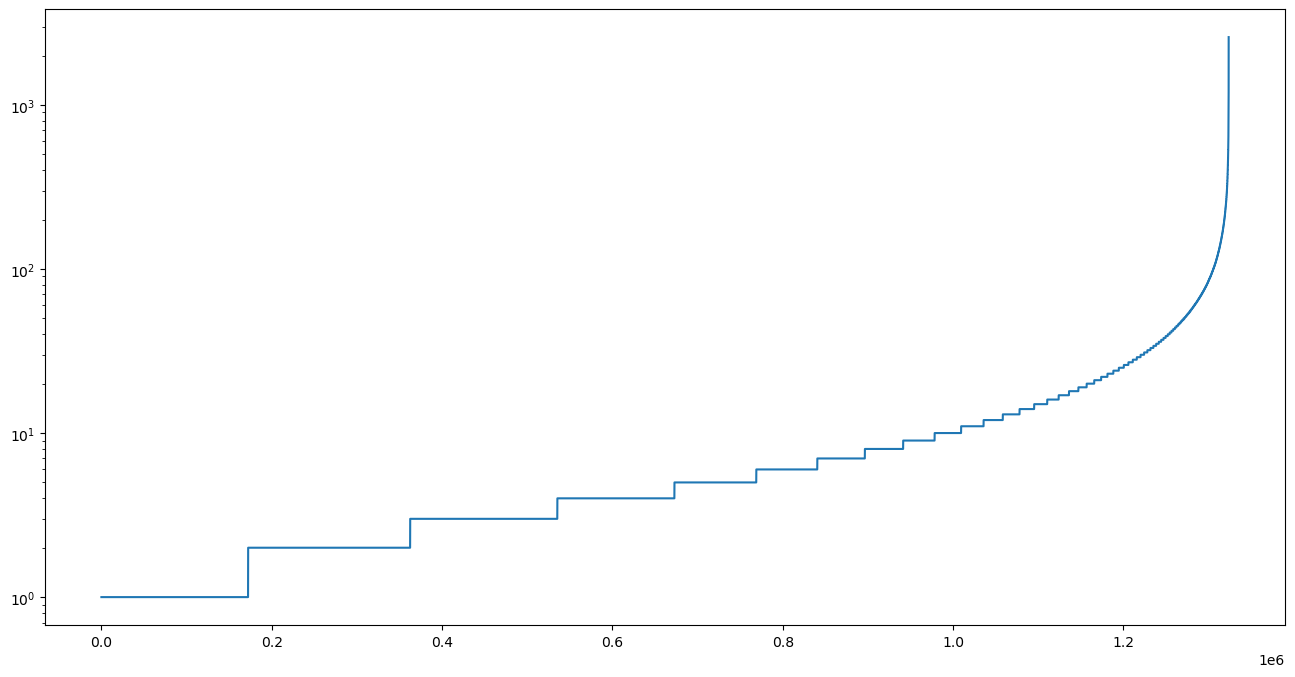

In [ ]:
plt.figure(figsize = (16,8))
plt.semilogy(counts.sort_values().values)

In [19]:
def get_dicts(sessions):
    _dict = collections.defaultdict(dict)
    for session in tqdm(sessions.prev_items.values):
        for (x, y) in itertools.permutations(session, 2):
            if y in _dict[x].keys():
                _dict[x][y] = _dict[x][y]+1
            else:
                _dict[x][y] = 1
    return _dict

occasions = get_dicts(sessions)

100%|██████████| 3606249/3606249 [00:31<00:00, 115957.44it/s]


In [20]:
PREDS_PER_SESSION = 100
task = 'task1'
def random_predicitons(locale, sess_test_locale):
    random_state = np.random.RandomState(42)
    products = read_product_data().query(f'locale == "{locale}"')
    predictions = []
    for _ in range(len(sess_test_locale)):
        predictions.append(
            list(products['id'].sample(PREDS_PER_SESSION, replace=True, random_state=random_state))
        ) 
    sess_test_locale['next_item_prediction'] = predictions
    sess_test_locale.drop('prev_items', inplace=True, axis=1)
    return sess_test_locale

In [ ]:
def historical_predictions(locale, sess_test_locale, occasions):
    random_state = np.random.RandomState(42)
    products = read_product_data().query(f'locale == "{locale}"')
    predictions = []
    for i in range(len(sess_test_locale)):
        prev_items = sess_test_locale.iloc[i].prev_items
        prev_items = json.loads(prev_items.replace(' ', ',').replace('\'', '"'))
        _dict = {}
        for prev_item in prev_items:
            for k, v in occasions[prev_item].items():
                if k in _dict:
                    _dict[k] = _dict[k] + v
                else:
                    _dict[k] = v
        _dict = dict(sorted(_dict.items(), key = lambda item: item[1], reverse = True))
        if len(_dict) > PREDS_PER_SESSION:
            prediction = list(_dict.keys())[:PREDS_PER_SESSION]
        else:
            prediction = list(_dict.keys()) + list(products['id'].sample(PREDS_PER_SESSION - len(_dict), replace=True, random_state=random_state))
        predictions.append(prediction) 
    sess_test_locale['next_item_prediction'] = predictions
    sess_test_locale.drop('prev_items', inplace=True, axis=1)
    return sess_test_locale

In [ ]:
test_sessions = read_test_data(task)
predictions = []
test_locale_names = test_sessions['locale'].unique()
for locale in test_locale_names:
    sess_test_locale = test_sessions.query(f'locale == "{locale}"').copy()
    predictions.append(historical_predictions(locale, sess_test_locale, occasions))
predictions = pd.concat(predictions).reset_index(drop=True)
predictions.sample(5)

In [11]:
def check_predictions(predictions, check_products=False):
    """
    These tests need to pass as they will also be applied on the evaluator
    """
    test_locale_names = test_sessions['locale'].unique()
    for locale in test_locale_names:
        sess_test = test_sessions.query(f'locale == "{locale}"')
        preds_locale =  predictions[predictions['locale'] == sess_test['locale'].iloc[0]]
        assert sorted(preds_locale.index.values) == sorted(sess_test.index.values), f"Session ids of {locale} doesn't match"

        if check_products:
            # This check is not done on the evaluator
            # but you can run it to verify there is no mixing of products between locales
            # Since the ground truth next item will always belong to the same locale
            # Warning - This can be slow to run
            products = read_product_data().query(f'locale == "{locale}"')
            predicted_products = np.unique( np.array(list(preds_locale["next_item_prediction"].values)) )
            assert np.all( np.isin(predicted_products, products['id']) ), f"Invalid products in {locale} predictions"

In [ ]:
check_predictions(predictions)

In [ ]:
predictions.to_parquet(f'submission_{task}.parquet', engine='pyarrow')

In [ ]:
!aicrowd submission create -c task-1-next-product-recommendation -f "submission_task1.parquet"

In [ ]:
task = 'task2'
test_sessions = read_test_data(task)
predictions = []
test_locale_names = test_sessions['locale'].unique()
for locale in test_locale_names:
    sess_test_locale = test_sessions.query(f'locale == "{locale}"').copy()
    predictions.append(historical_predictions(locale, sess_test_locale, occassions))
predictions = pd.concat(predictions).reset_index(drop=True)
predictions.sample(5)

In [ ]:
check_predictions(predictions)

In [ ]:
predictions.to_parquet(f'submission_{task}.parquet', engine='pyarrow')
!aicrowd submission create -c task-2-next-product-recommendation-for-underrepresented-languages -f "submission_task2.parquet"